<a href="https://colab.research.google.com/github/Jackil1993/RLSC/blob/main/RLSC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install all the necessary dependencies 
!pip install -Iv ray==1.0.0
!pip install or-gym
!pip install numpy==1.19.5
!pip install lz4
#Restart runtime after that 

In [ ]:
import or_gym
from or_gym.utils import create_env
import ray
from ray.rllib import agents
from ray import tune
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.optimize import minimize

# Environment and RL Configuration Settings
env_name = 'InvManagement-v1'

env_config = {'I0': [100, 120, 150, 150],
              'p': 4.1,
              'dist': 1,
              'dist_param': {'mu': 20},
              'seed_int': 0,
              'max_rewards': 1000,
              'backlog': False,
              'r': [1.0, 1.0, 0.75, 0.5, 0.5],
              'k': [0.10, 0.075, 0.05, 0.025, 0.025],
              'h': [0.10, 0.10, 0.05, 0.05],
              'c':[120, 100, 100, 90],
              'L': [3, 5, 7, 7],
              'periods': 30}
env = or_gym.make('InvManagement-v1', env_config=env_config)


def register_env(env_name, env_config=env_config):
    env = create_env(env_name)
    tune.register_env(env_name,
        lambda env_name: env(env_name,
            env_config=env_config))

rl_config = dict(
    env=env_name,
    num_workers=2,
    env_config=env_config,
    model=dict(
        vf_share_layers=False,
        fcnet_activation='relu',
        fcnet_hiddens=[512]
    ),
    lr=1e-5,
    train_batch_size=4000

)
# Register environment
register_env(env_name, env_config)

# Initialize Ray and Build Agent
ray.init(ignore_reinit_error=True)
agent = agents.ppo.PPOTrainer(env=env_name, config=rl_config)
results = []
for i in range(300):
    res = agent.train()
    if i %5 == 0:
      print(i)
    results.append(res)

In [ ]:
def base_stock_policy(policy, env):

    assert len(policy) == len(env.init_inv), (
        'Policy should match number of nodes in network' +
        '({}, {}).'.format(
            len(policy), len(env.init_inv)))
     
    # Get echelon inventory levels
    if env.period == 0:
        inv_ech = np.cumsum(env.I[env.period] +
            env.T[env.period])
    else:
        inv_ech = np.cumsum(env.I[env.period] +
            env.T[env.period] - env.B[env.period-1, :-1])
         
    # Get unconstrained actions
    unc_actions = policy - inv_ech
    unc_actions = np.where(unc_actions>0, unc_actions, 0)
     
    # Ensure that actions can be fulfilled by checking 
    # constraints
    inv_const = np.hstack([env.I[env.period, 1:], np.Inf])
    actions = np.minimum(env.c,
                np.minimum(unc_actions, inv_const))
    return actions


def dfo_func(policy, env, *args):

    env.reset() # Ensure env is fresh
    rewards = []
    done = False
    while not done:
        action = base_stock_policy(policy, env)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
             
    rewards = np.array(rewards)
    prob = env.demand_dist.pmf(env.D, **env.dist_param)
     
    # Return negative of expected profit
    return -1 / env.num_periods * np.sum(prob * rewards)


def optimize_inventory_policy(env_name, fun,
    init_policy=None, env_config={}, method='Powell'):
     
    env = or_gym.make(env_name, env_config=env_config)
     
    if init_policy is None:
        init_policy = np.ones(env.num_stages-1)
         
    # Optimize policy
    out = minimize(fun=fun, x0=init_policy, args=env, 
        method=method)
    policy = out.x.copy()
     
    # Policy must be positive integer
    policy = np.round(np.maximum(policy, 0), 0).astype(int)
     
    return policy, out


policy, out = optimize_inventory_policy('InvManagement-v1', dfo_func, env_config=env_config)
print("Re-order levels: {}".format(policy))
print("DFO Info:\n{}".format(out))

In [ ]:
rewards = np.hstack([i['hist_stats']['episode_reward']
    for i in results])


env = or_gym.make(env_name, env_config=env_config)
print(len(rewards))
eps = len(rewards)
rewards_ss = []
for i in range(eps):
    if i %10000 == 0:
      print(i)
    env.reset()
    reward = 0
    while True:
        action = base_stock_policy(policy, env)
        s, r, done, _ = env.step(action)
        reward += r
        if done:
            rewards_ss.append(reward)
            break


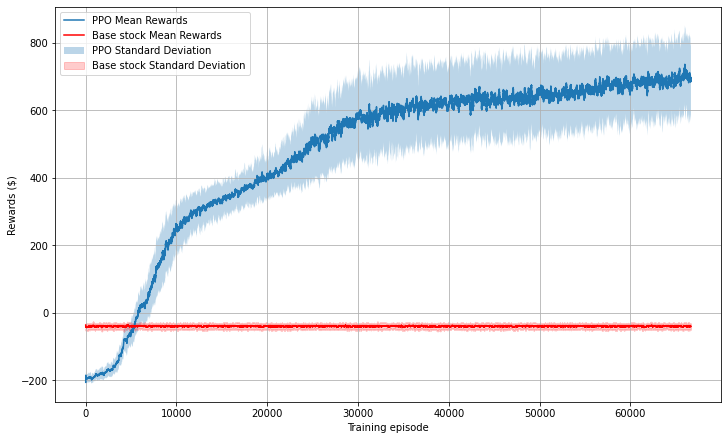

In [ ]:
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1])
                if i >= p else np.mean(rewards[:i+1])
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
#gs = fig.add_gridspec(2, 4)
#ax0 = fig.add_subplot(gs[:, :-2])
plt.fill_between(np.arange(len(mean_rewards)),
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 label='PPO Standard Deviation', alpha=0.3)
plt.plot(mean_rewards, label='PPO Mean Rewards')



ss_mean_rewards = np.array([np.mean(rewards_ss[i-p:i+1])
                if i >= p else np.mean(rewards_ss[:i+1])
                for i, _ in enumerate(rewards_ss)])
ss_std_rewards = np.array([np.std(rewards_ss[i-p:i+1])
               if i >= p else np.std(rewards_ss[:i+1])
               for i, _ in enumerate(rewards_ss)])
#fig = plt.figure(constrained_layout=True, figsize=(15, 5))
#gs = fig.add_gridspec(2, 4)
#ax0 = fig.add_subplot(gs[:, :-2])
plt.fill_between(np.arange(len(ss_mean_rewards)),
                 ss_mean_rewards - ss_std_rewards,
                 ss_mean_rewards + ss_std_rewards,
                 color='red',
                 label='Base stock Standard Deviation', alpha=0.2)
plt.plot(ss_mean_rewards, color='red', label='Base stock Mean Rewards')


plt.ylabel('Rewards ($)')
plt.xlabel('Training episode')
#ax0.set_title('Training Rewards')
#plt.xlim((0, 70000))
plt.legend()
plt.grid()
plt.show()

In [ ]:
trials = 100
observations = [[] for i in range(trials)]

for i in range(trials):
  episode_reward = 0
  done = False
  obs = env.reset()
  while not done:
    action = agent.compute_action(obs)
    #ction = base_stock_policy(policy, env)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    observations[i].append(obs)
  ray.shutdown()

80.17


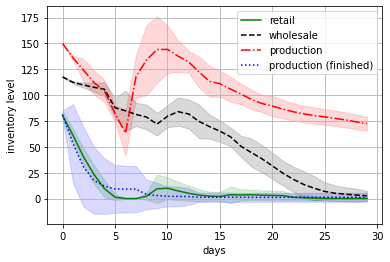

In [ ]:
inv1 = []
inv2 = []
inv3 = []
inv4 = []
std_inv1 = []
std_inv2 = []
std_inv3 = []
std_inv4 = []

days = []


data = np.array(observations)
m_data = np.mean(data, axis=0)
std_data = np.std(data, axis=0)

#print(m_data[:, 0:4])
print(m_data[0, 0])
for i in range(30):
  inv1.append(m_data[i, 0])
  std_inv1.append(std_data[i, 0])
  inv2.append(m_data[i, 1])
  std_inv2.append(std_data[i, 1])
  inv3.append(m_data[i, 2])
  std_inv3.append(std_data[i, 2])
  inv4.append(m_data[i, 3])
  std_inv4.append(std_data[i, 3])
  days.append(i)
#fig = plt.figure(constrained_layout=True, figsize=(30, 10))
plt.plot(days, inv1, color='green', label='retail')
plt.fill_between(days,
                np.array(inv1) - np.array(std_inv1),
                 np.array(inv1) + np.array(std_inv1), color='green', alpha=0.15)
plt.plot(days, inv2, '--', color='black', label='wholesale')
plt.fill_between(days,
                np.array(inv2) - np.array(std_inv2),
                 np.array(inv2) + np.array(std_inv2), color='black', alpha=0.15)
plt.plot(days, inv3, '-.', color='red', label='production')
#(semi-finished)
plt.fill_between(days,
                np.array(inv3) - np.array(std_inv3),
                 np.array(inv3) + np.array(std_inv3), color='red', alpha=0.15)

plt.plot(days, inv4, ':', color='blue', label='production (finished)')
plt.fill_between(days,
                np.array(inv4) - np.array(std_inv4),
                 np.array(inv4) + np.array(std_inv4), color='blue', alpha=0.15)
#plt.xlim((0, 14))
plt.grid()
plt.legend()
plt.xlabel('days')
plt.ylabel('inventory level')
plt.show()

In [ ]:
print(np.mean(rewards_ss[-500:]))
print(np.std(rewards_ss[-500:]))
print(np.std(rewards_ss[-500:])/np.mean(rewards_ss[-500:]))
print('---------')
print(np.mean(rewards[-500:]))
print(np.std(rewards[-500:]))
print(np.std(rewards[-500:])/np.mean(rewards[-500:]))
print('---------')
print(np.mean(rewards[-500:])/np.mean(rewards_ss[-500:]))

-40.08490270698657
9.084817402388248
-0.22663937764291534
---------
892.0133954450914
46.79869889153564
0.05246412120098747
---------
-22.25310117291662
